Data loaded: (29531, 16)


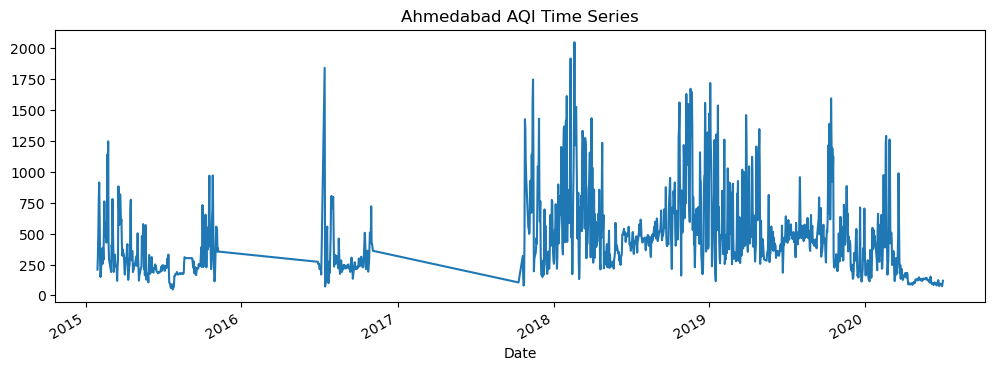

Data: 1334 points from 2015-01-29 00:00:00 to 2020-07-01 00:00:00
Training ARIMA...


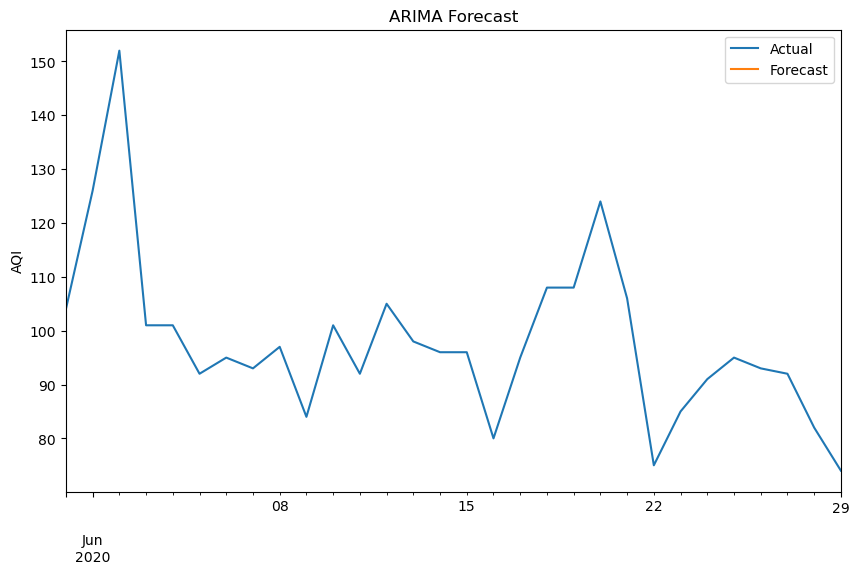

Training Exponential Smoothing...


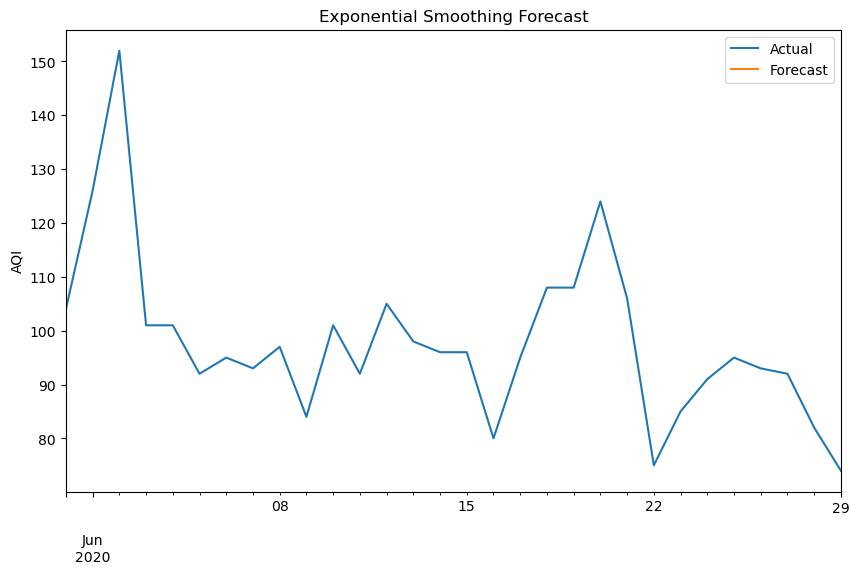

11:54:55 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet...


11:54:55 - cmdstanpy - INFO - Chain [1] done processing


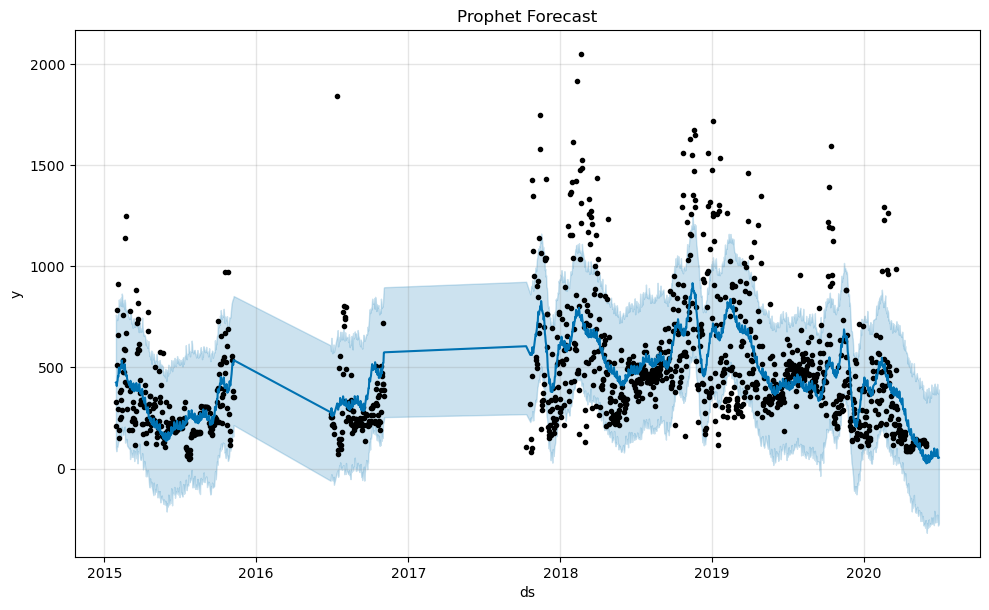

Training LSTM...


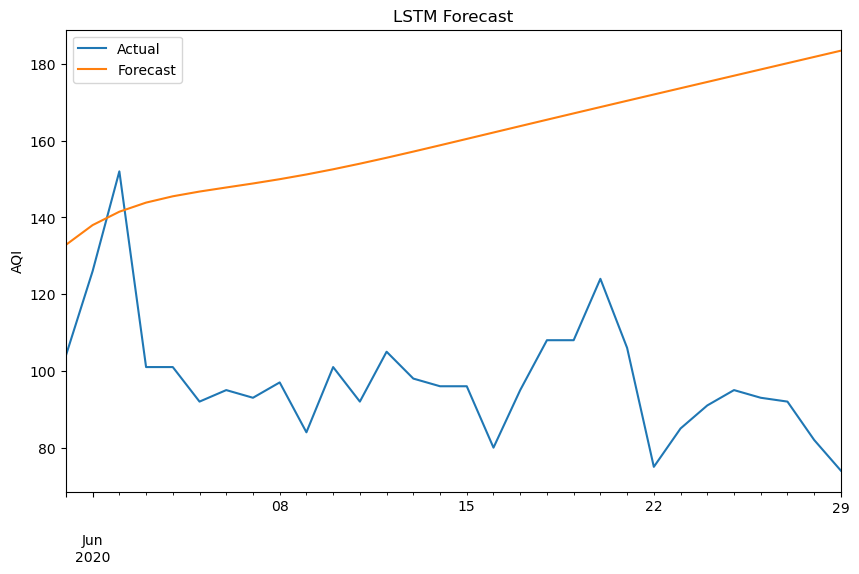


30-Day AQI Forecasts (All Models):
           Date   ARIMA  ExpSmooth  Prophet        LSTM
1304 2020-05-31  119.64     115.36    31.83  132.850006
1305 2020-06-01  125.08     140.93    30.19  138.000000
1306 2020-06-02  127.15     124.68    42.68  141.490005
1307 2020-06-03  127.94     107.21    29.84  143.860001
1308 2020-06-04  128.24     122.80    66.69  145.500000
1309 2020-06-05  128.35     106.83    54.70  146.740005
1310 2020-06-06  128.40     120.78    31.26  147.800003
1311 2020-06-07  128.41     115.36    40.90  148.839996
1312 2020-06-08  128.42     140.93    42.10  149.960007
1313 2020-06-09  128.42     124.68    57.05  151.190002
1314 2020-06-10  128.42     107.21    46.24  152.539993
1315 2020-06-11  128.42     122.80    84.65  154.000000
1316 2020-06-12  128.42     106.83    73.71  155.550003
1317 2020-06-13  128.42     120.78    50.80  157.149994
1318 2020-06-14  128.42     115.36    60.44  158.789993
1319 2020-06-15  128.42     140.93    61.14  160.460007
1320 2020-06

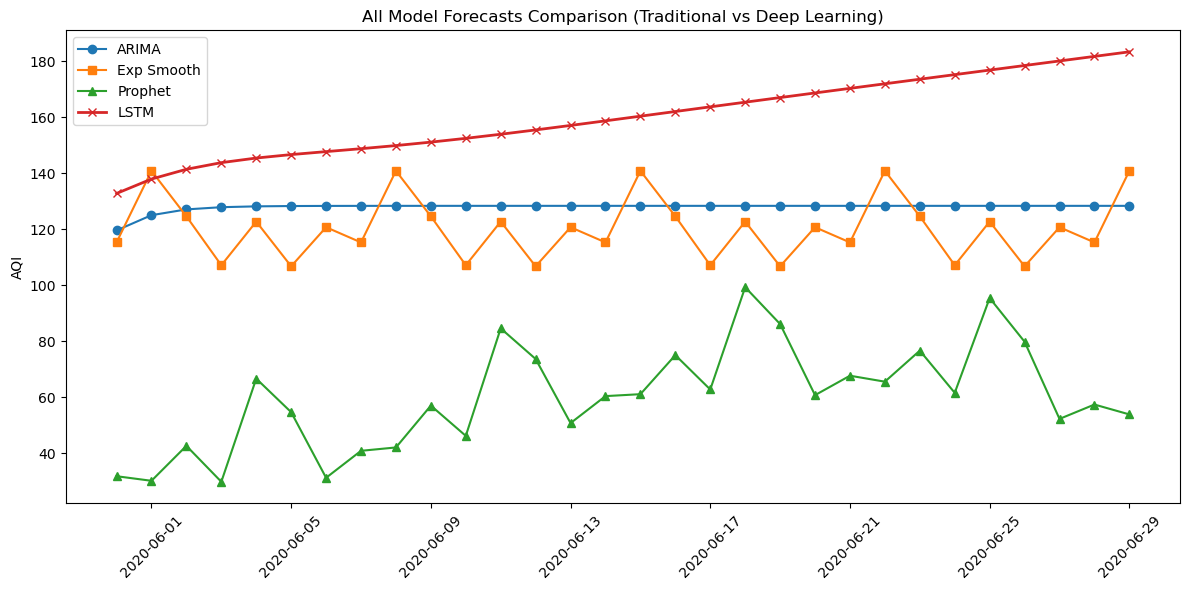

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

# New imports for LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. Load data
df = pd.read_csv('city_aqi.csv')
print("Data loaded:", df.shape)

# Filter Ahmedabad + remove duplicates
df_ahmedabad = df[df['City']=='Ahmedabad'].copy()
df_ahmedabad['Date'] = pd.to_datetime(df_ahmedabad['Date'])
df_ahmedabad = df_ahmedabad.sort_values('Date')
df_ahmedabad = df_ahmedabad[~df_ahmedabad['Date'].duplicated(keep='first')]
df_ahmedabad = df_ahmedabad.set_index('Date')
ts = df_ahmedabad['AQI'].dropna()

ts.plot(figsize=(12,4), title="Ahmedabad AQI Time Series")
plt.show()
print(f"Data: {len(ts)} points from {ts.index.min()} to {ts.index.max()}")

# Define forecast horizon
n_forecast = 30
dates = pd.date_range(start=ts.index[-n_forecast], periods=n_forecast, freq='D')

# ---------------------------------------------------------
# Model 1: ARIMA 
# ---------------------------------------------------------
print("Training ARIMA...")
# Note: Using ts[:-30] to ensure we predict the "test" period
model_arima = auto_arima(ts[:-n_forecast], seasonal=True, m=7)
arima_forecast = model_arima.predict(n_periods=n_forecast)

plot_df = pd.DataFrame({
    'Actual': ts[-n_forecast:].reindex(dates, method='nearest').values,
    'Forecast': arima_forecast
}, index=dates)
plot_df.plot(figsize=(10,6), title="ARIMA Forecast")
plt.ylabel('AQI')
plt.show()

# ---------------------------------------------------------
# Model 2: Exponential Smoothing 
# ---------------------------------------------------------
print("Training Exponential Smoothing...")
train = ts[:-n_forecast]
model_es = ExponentialSmoothing(train, seasonal='add', seasonal_periods=7).fit()
es_forecast = model_es.forecast(n_forecast)

plot_df_es = pd.DataFrame({
    'Actual': ts[-n_forecast:].reindex(dates, method='nearest').values,
    'Forecast': es_forecast
}, index=dates)
plot_df_es.plot(figsize=(10,6), title="Exponential Smoothing Forecast")
plt.ylabel('AQI')
plt.show()

# ---------------------------------------------------------
# Model 3: Prophet 
# ---------------------------------------------------------
print("Training Prophet...")
df_prophet = ts.reset_index().rename(columns={'Date':'ds', 'AQI':'y'})
m = Prophet(daily_seasonality=True)
m.fit(df_prophet[:-n_forecast])
future = m.make_future_dataframe(periods=n_forecast)
prophet_forecast = m.predict(future)
m.plot(prophet_forecast)
plt.title("Prophet Forecast")
plt.show()

# ---------------------------------------------------------
# Model 4: LSTM (Long Short-Term Memory) - NEW ADDITION
# ---------------------------------------------------------
print("Training LSTM...")

# 1. Scale data (LSTMs are sensitive to scale)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ts.values.reshape(-1, 1))

# 2. Prepare training sequences
# We use the train split (excluding last 30 days) to train the LSTM
train_scaled = scaled_data[:-n_forecast]
look_back = 60  # Use past 60 days to predict next day

X_train, y_train = [], []
for i in range(look_back, len(train_scaled)):
    X_train.append(train_scaled[i-look_back:i, 0])
    y_train.append(train_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# 3. Build LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=False, input_shape=(look_back, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# 4. Train
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

# 5. Forecast (Recursive Strategy)
# Start with the last 'look_back' days of the training set
curr_input = train_scaled[-look_back:].reshape(1, look_back, 1)
lstm_preds_scaled = []

for i in range(n_forecast):
    # Predict next step
    pred = model_lstm.predict(curr_input, verbose=0)
    lstm_preds_scaled.append(pred[0,0])
    
    # Update input window: remove first day, add new prediction
    curr_input = np.append(curr_input[:,1:,:], [pred], axis=1)

# 6. Inverse scale predictions back to AQI values
lstm_forecast = scaler.inverse_transform(np.array(lstm_preds_scaled).reshape(-1, 1)).flatten()

# Plot LSTM individual result
plot_df_lstm = pd.DataFrame({
    'Actual': ts[-n_forecast:].reindex(dates, method='nearest').values,
    'Forecast': lstm_forecast
}, index=dates)
plot_df_lstm.plot(figsize=(10,6), title="LSTM Forecast")
plt.ylabel('AQI')
plt.show()

# ---------------------------------------------------------
# Final Comparison & Results Table
# ---------------------------------------------------------
results = pd.DataFrame({
    'Date': dates,                  
    'ARIMA': arima_forecast,         
    'ExpSmooth': es_forecast,         
    'Prophet': prophet_forecast['yhat'].tail(n_forecast).values,
    'LSTM': lstm_forecast
})

results.to_csv('aqi_forecasts.csv', index=False)
print("\n30-Day AQI Forecasts (All Models):")
print(results.round(2))

plt.figure(figsize=(12,6))
plt.plot(results['Date'], results['ARIMA'], label='ARIMA', marker='o')
plt.plot(results['Date'], results['ExpSmooth'], label='Exp Smooth', marker='s')
plt.plot(results['Date'], results['Prophet'], label='Prophet', marker='^')
plt.plot(results['Date'], results['LSTM'], label='LSTM', marker='x', linewidth=2) # Added LSTM to plot
plt.legend()
plt.title('All Model Forecasts Comparison (Traditional vs Deep Learning)')
plt.ylabel('AQI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()